In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

In [2]:
"""" Results' columns' description 
'neuron':  neuron name extracted from file name
'subtype': neuron name extracted from file name
'entry_point': entry point of the neuron, read from seperate txt file

'volume': volume of the masked 3D image in um3
'3D_convex_volume': volume of the convex-hull for the 3D image in um3
'net_area': area of the object in the 2D image (the 2D is a max projection of the 3D image) in um2
'area': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops) in um2 

'density_2D': solidity value obtained from skimage.measure.regionprops on the 2D image
'density_3D': pixel count of 3D image/pixel count of 3D convexhull 
'object_perimeter': object perimenter value obtained from skimage.measure.regionprops on the 2D image
'convex_perimeter': perimeter of the surronding convex_hull

'AP_spread': (max-min) of value pixels index in last (x) dimension of the 2D image in um
'DV_spread': (max-min) of value pixels index in (y) dimension of the 2D image in um                
'ellipticity': (elipse_major - elipse_minor)/ elipse_major
'PCA_elongation': (max_eign_value - min_eign_value)/ max_eign_value
'eccentricity': eccentricity value obtained from skimage.measure.regionprops on the 2D image 
'circularity': (4*np.pi*convex_area)/(convex_perimeter**2)


'compactness': object_perimeter**2/(4*np.pi*net_area)
'surface_area': mesh_surface_area of the marching_cubes on the 3D masked image in um2
'3D_convex_surface': mesh_surface_area of the marching_cubes on the 3D masked image in um2



'convexity_2D': convex_perimeter/object_perimeter
'convexity_3D': 3D_convex_surface/surface_area
'orientation': orientation value obtained from skimage.measure.regionprops on the 2D image 
'feret_diameter_max': feret_diameter_max value obtained from skimage.measure.regionprops on the 2D image 

'centroidZ': Z position of the centroid from regionprops on the 3D masked image 
'centroidY': Y position of the centroid from regionprops on the 3D masked image 
'centroidX': X position of the centroid from regionprops on the 3D masked image 
'cen_EP_dis': ecludian distance of the centroid from the entry point
'cen_EP_angle': angle of the line between centroid from the entry point (np.arctan2)
'cen_EP_y', 'cen_EP_x': the x,y position of the centroid with the entry point as center (0,0) 

£££ PCA analysis
'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry': different attempts for asymmetry calculation (all bad)

'xP_weight', 'xP_scale','xP_angle','xP_xy':
'xN_weight','xN_scale','xN_angle','xN_xy',
'yP_weight','yP_scale','yP_angle','yP_xy',
'yN_weight','yN_scale','yN_angle','yN_xy',
'PCA_angle':
'PCA_xy':
'PCA_shift_centroid_y', 'PCA_shift_centroid_x': position of the 2D_image centroid after shifting according to PCA

'DGI': from the old script 
"""

#The pixel resolution has to be provided to calculate everything in um(n) 

'" Results\' columns\' description \n\'neuron\':  neuron name extracted from file name\n\'subtype\': neuron name extracted from file name\n\'entry_point\': entry point of the neuron, read from seperate txt file\n\n\'volume\': volume of the masked 3D image in um3\n\'3D_convex_volume\': volume of the convex-hull for the 3D image in um3\n\'net_area\': area of the object in the 2D image (the 2D is a max projection of the 3D image) in um2\n\'area\': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops) in um2 \n\n\'density_2D\': solidity value obtained from skimage.measure.regionprops on the 2D image\n\'density_3D\': pixel count of 3D image/pixel count of 3D convexhull \n\'object_perimeter\': object perimenter value obtained from skimage.measure.regionprops on the 2D image\n\'convex_perimeter\': perimeter of the surronding convex_hull\n\n\'AP_spread\': (max-min) of value pixels index in last (x) dimension of the 2D image in um\n\'DV_spread\': (max-min) 

In [1]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/controls/adult_1/'
save_path = '/home/tli_project/Desktop/Data/controls/adult_1/output/'
result_csv_file = 'analysis_result.csv'
px_resolution = (0.4, 0.076, 0.076) #z,y,x resolution
sig = 2 #sigma value used for creating mask

In [2]:
from tqdm import tqdm
import os
import re
import tifffile as tif

from scipy import ndimage
from skimage.filters import gaussian, threshold_otsu
import operator

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [3]:
# functions

def mask_image(volume, return_mask = False ,sig = 1):
    """
    Create a binary mask from a 2 or 3-dimensional np.array.
    Method normalizes the image, converts it to greyscale, then applies gaussian bluring (kernel width set to 2 by default, can be changed with sig parameter).
    This is followed by thresholding the image using the isodata method and returning a binary mask. 
    Parameters
    ----------
    image           np.array
                    np.array of an image (2 or 3D)
    return_mask     bool
                    If False (default), the mask is subtracted from the original image. If True, a boolian array is returned, of the shape of the original image, as a mask. 
    sig             Int
                    kernel width for gaussian smoothing. set to 2 by default.
    Returns
    -------
    mask            np.array
                    Returns a binary np.array of equal shape to the original image, labeling the masked area.
    """
    image = volume.copy()
    image = image.astype('float32')
    image -= image.min()
    image /= image.max()
    blur = gaussian(image, sigma=sig)
    t = threshold_otsu(blur)
    mask = blur > t
    mask = np.array(mask, dtype=bool)
    if return_mask == False:
        image[mask==False] = 0
        mask = image
    return mask

def segment_3D(image):
    s = ndimage.generate_binary_structure(len(image.shape), len(image.shape))
    labeled_array, num_labels = ndimage.label(image, structure=s)
    labels = np.unique(labeled_array)
    labels = labels[labels!=0]
    neu_sizes = {}
    for l in labels:
        neu_sizes[l] = (labeled_array == l).sum()/(labeled_array == l).max()
    avg_size = np.mean(list(neu_sizes.values()))
    sorted_sizes = sorted(neu_sizes.items(), key=operator.itemgetter(1), reverse=True)
    labels = [[l][0][0] for l in sorted_sizes]
    neuron = labeled_array.copy()
    neuron[neuron != labels[0]] = 0
    neuron[neuron == labels[0]] = 1
    neuron = neuron.astype('uint8')      
    return neuron

def DGI_3D(image, entry_point):
    """
    This function takes a 4D array of a neuron and calculates its directional growth indext (DGI) from the entry point based on the the formula:

    DGI = length(V)/length(sum(|Vi|))

    It returns a datafram containing the values of the orientation vector for each time point.
    
    Parameter:
    entry_point:    Array with 4 values that correspond to the entry point of the dendrite into the neuropil. Values correspond to the 'TZYX' coordinates of the point.
    
    neuron:         4D array containing the dendrite to analyze. It should only contain parts of the dendrite.
    """
    pixel_co = np.argwhere(image)
    # shifting all points to make entry point the center of (0,0,0)
    norm_pixel_values = pixel_co - entry_point
    norm_pixel_values[:,1] *= -1 ##### to reverse the Y axis numbering upward 
    vec_length = np.linalg.norm(norm_pixel_values, axis=1) # sum all points_vectors (maximum length)
    dbp_index = np.argwhere(vec_length == 0)
    norm_pixel_values = np.delete(norm_pixel_values, (dbp_index), axis=0)
    vec_length = np.delete(vec_length, dbp_index)
    ori_vec = norm_pixel_values.sum(axis=0) #calculate (Z,Y,X) of vector sum
    ori_vec_length = np.linalg.norm(ori_vec) #Calculate the length of vector sum
    Dgi = ori_vec_length/vec_length.sum() #calculate DGI which is maximum_length/length_vect_sum 
    av_vect = norm_pixel_values.mean(axis=0)
    av_vect_length = np.linalg.norm(av_vect)   
    return Dgi

def rotate(origin, point, angle, direction = 'counterclockwise'):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    if direction == 'counterclockwise':
        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    elif direction == 'clockwise':
        qx = ox + math.cos(angle) * (px - ox) + math.sin(angle) * (py - oy)
        qy = oy - math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    return qx, qy

def angle_between(p1,p2):
    """
    angle beteen 2 points
    """
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1-ang2 % (2 * np.pi)))

#everything as one...
def metric_dump(image,entry_point,plot=False):
    """

    """
    coords = (np.argwhere(image) - entry_point).T
    coords = np.vstack((coords[1],coords[0]))

    # find the covariance matrix:
    cov_mat = np.cov(coords)

    # get eigen vectors and values
    evals, evecs = np.linalg.eig(cov_mat)

    # get the order of the eigen values and sort the eigenvectors
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    # calculate the angle of rotation of the eigenvectors relative to the original coordinate space and get the rotation matrix
    theta = np.arctan((x_v1)/(y_v1))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])

    inv_rot_mat = np.linalg.inv(rotation_mat)

    # rotate the original coordinates
    rotated_coords = rotation_mat * coords

    # plot the transformed blob
    x_transformed, y_transformed = rotated_coords.A

    # we want the minimum and maximum values along each axis
    x_max = np.max(x_transformed)
    x_min = np.min(x_transformed)
    y_max = np.max(y_transformed)
    y_min = np.min(y_transformed)

    # the fraction of pixels in each direction
    frac_x_pos = len(x_transformed[x_transformed>0])/len(x_transformed)
    frac_x_neg = 1 - frac_x_pos
    frac_y_pos = len(y_transformed[y_transformed>0])/len(y_transformed)
    frac_y_neg = 1 - frac_y_pos

    # The difference
    diff_x = abs(frac_x_pos - frac_x_neg)
    diff_y = abs(frac_y_pos - frac_y_neg)

    # then the difference times the fraction in that direction
    x_pos = diff_x * frac_x_pos
    x_neg = diff_x * frac_x_neg
    y_pos = diff_y * frac_y_pos
    y_neg = diff_y * frac_y_neg

    # and finally, multiply by the scalar value from the first point. 
    final_x_pos = x_max * x_pos
    final_x_neg = x_min * x_neg
    final_y_pos = y_max * y_pos
    final_y_neg = y_min * y_neg

    ## sort out the vectors - we have the points, and the origin is [0,0], so rotate the second point by -theta degrees

    x_pos_final = rotate(origin = [0,0], point = [final_x_pos,0], angle = theta, direction = 'clockwise')
    x_neg_final = rotate(origin = [0,0], point = [final_x_neg,0], angle = theta, direction = 'clockwise')
    y_pos_final = rotate(origin = [0,0], point = [0,final_y_pos], angle = theta, direction = 'clockwise')
    y_neg_final = rotate(origin = [0,0], point = [0,final_y_neg], angle = theta, direction = 'clockwise')

    # get angle of each vector
    x_pos_angle = angle_between([0,0],x_pos_final)
    x_neg_angle = angle_between([0,0], x_neg_final)
    y_pos_angle = angle_between([0,0], y_pos_final)
    y_neg_angle = angle_between([0,0], y_neg_final)

    df = pd.DataFrame.from_dict({'axis':['x_positive','x_negative','y_positive','y_negative'],
                                'Fraction_weight':[x_pos,x_neg,y_pos,y_neg],
                                'Pixel_scale':[x_max,x_min,y_max,y_min],
                                'Angle':[x_pos_angle,x_neg_angle,y_pos_angle,y_neg_angle],
                                'xy': [x_pos_final,x_neg_final,y_pos_final,y_neg_final]})

    asymmetry = (diff_x + diff_y)/2
    x_asymmetry = min(frac_x_neg,frac_x_pos)*min(x_max,abs(x_min))/(max(frac_x_neg,frac_x_pos)*max(x_max,abs(x_min)))
    y_asymmetry = min(frac_y_neg,frac_y_pos)*min(y_max,abs(y_min))/(max(frac_y_neg,frac_y_pos)*max(y_max,abs(y_min)))
    x_scale = x_pos+abs(x_neg)
    y_scale = y_pos+abs(y_neg)
    if x_scale > y_scale:
        PC1_asymmetry = x_asymmetry
        PC2_asymmetry = y_asymmetry
    else:
        PC1_asymmetry = y_asymmetry
        PC2_asymmetry = x_asymmetry
    
    asymmetries = [asymmetry, x_asymmetry, y_asymmetry, PC1_asymmetry, PC2_asymmetry]

    if plot:
        x, y = coords[0], coords[1]
        cent_x = x_transformed.mean()
        cent_y = y_transformed.mean()
        scale = 20
        plt.scatter(x, y, marker='.',c='k',alpha=0.2)
        plt.plot([x_v1*-scale*2, x_v1*scale*2],
                [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
                [y_v2*-scale, y_v2*scale], color='blue')
        # plt.plot(x, y, 'k.')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()
        # x_transformed, y_transformed = transformed_mat.A
        plt.plot(x_transformed, y_transformed, 'g.',alpha=0.1)
        plt.scatter(cent_x,cent_y,c='k')
        plt.text(cent_x+5,cent_y+5,'centroid')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

    return asymmetries, df, rotated_coords.A.T, evals

def process_image(neu_file,results_df):
    neu_res = {}
    # getting entry point
    try:
        neu_res['subtype'] = neu_file[-5]
    except:
        neu_res['subtype'] = 'N'
    # neu_res['neuron'] = neu_file.rstrip('.tif')
    neu_res['neuron'] = neu_file[:-6]
    entry_point = np.array(entry_points[neu_res['neuron']])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)

    # mask and binarize neuron
    mask = mask_image(image, return_mask = False ,sig = sig)
    mask = segment_3D(mask)
    image[mask ==0] = 0
    image[image!=0] = 1

    neu_res['entry_point'] = entry_point

    neu_res['volume'] = image.sum()*px_resolution.prod()
    img_2D = image.max(axis=0)
    img_2D[img_2D!=0] = 1
    neu_res['net_area'] = img_2D.sum()*px_resolution[1:].prod()
    reg_prop_2D = regionprops(img_2D)[0]
    neu_res['density_2D'] = reg_prop_2D.solidity
    neu_res['area'] = reg_prop_2D.area_convex*px_resolution[1:].prod()
    neu_res['orientation'] = reg_prop_2D.orientation * (180/np.pi)
    neu_res['eccentricity'] = reg_prop_2D.eccentricity
    neu_res['ellipticity'] = (reg_prop_2D.axis_major_length - reg_prop_2D.axis_minor_length)/reg_prop_2D.axis_major_length
    
    neu_res['feret_diameter_max'] = reg_prop_2D.feret_diameter_max*px_resolution[-1]
    neu_res['convex_perimeter'] = perimeter(reg_prop_2D.image_convex)*px_resolution[-1]
    neu_res['object_perimeter'] = reg_prop_2D.perimeter*px_resolution[-1]
    neu_res['convexity_2D'] = neu_res['convex_perimeter']/neu_res['object_perimeter']
    neu_res['circularity'] = (4*np.pi*neu_res['area'])/(neu_res['convex_perimeter']**2)
    neu_res['compactness'] = (4*np.pi*neu_res['net_area']) / neu_res['object_perimeter']**2

    reg_prop_3D = regionprops(image)[0]
    convex_img_3D = reg_prop_3D.image_convex*px_resolution.prod()
    neu_res['3D_convex_volume'] = reg_prop_3D.area_convex*px_resolution.prod()
    neu_res['density_3D'] = neu_res['volume']/neu_res['3D_convex_volume']
    
    centroid = np.array(reg_prop_3D.centroid)
    neu_res['centroidZ'],neu_res['centroidY'], neu_res['centroidX'], = centroid[0],centroid[1],centroid[2]
    p1 = centroid[1:] - entry_point[1:]
    neu_res['cen_EP_dis'] = np.linalg.norm(p1)*px_resolution[-1]
    neu_res['cen_EP_y'], neu_res['cen_EP_x'] = p1[0], p1[1]
    neu_res['cen_EP_angle'] = np.rad2deg(np.arctan2(*p1) % (2 * np.pi))
    
    # img_PC = reg_prop_3D.coords
    img_PC = np.argwhere(image)
    neu_res['DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*px_resolution[-1]
    neu_res['AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*px_resolution[-1]
    verts, faces, normals, values = marching_cubes(image, step_size=2, spacing=px_resolution)
    neu_res['surface_area'] = mesh_surface_area(verts, faces)
    verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=px_resolution)
    neu_res['3D_convex_surface'] = mesh_surface_area(verts, faces)
    neu_res['convexity_3D'] = neu_res['3D_convex_surface']/neu_res['surface_area']
    
    asymmetry_values, PCA_df, shifted_coor, evals = metric_dump(img_2D,entry_point[1:],plot=False)
    neu_res['PCA_elongation'] = (evals.max()-evals.min())/evals.max()
    # neu_res['PCA_elongation2'] = 
    asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
    for i,key in enumerate(asymmetries):
        neu_res[key] = asymmetry_values[i]

    # print(evals)

    PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy']
    PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
    result1 = {PCA_res[i]:val for i,val in enumerate(PCA_arr.ravel())}
    neu_res = neu_res | result1
    neu_res['PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle*-1
    # results_df.PC1_angle[results_df.PC1_angle>315] -= 360
    neu_res['PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
    neu_res['PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]
    PC1_shift_centroid = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
    neu_res['PC1_shift_centroid_y'], neu_res['PC1_shift_centroid_x'] = PC1_shift_centroid[0], PC1_shift_centroid[1]

    neu_res['DGI'] = DGI_3D(image,entry_point)

    # add the results as a new line to results_df
    neu_res = [neu_res[val] for val in results_cols]
    results_df.loc[neu_file] = neu_res


In [4]:
# getting list of image file names in data_path
N_folders = [name for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '.tif' in f]
N_folders = sorted(N_folders)
N_folders[:5]

['T4-02_A.tif', 'T4-03_D.tif', 'T4-04_B.tif', 'T4-05_D.tif', 'T4-06_D.tif']

In [5]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/home/tli_project/Desktop/Data/controls/adult_1/Adults_ctrl_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [6]:
results_cols = ['neuron','subtype', 'entry_point',
                'volume','3D_convex_volume', 'net_area', 'area',
                'AP_spread', 'DV_spread', 'eccentricity', 'ellipticity','PCA_elongation', 'circularity',
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'compactness', 'surface_area', '3D_convex_surface',
                'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max',
                'centroidZ','centroidY', 'centroidX', 
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_y', 'cen_EP_x',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PC1_angle','PC1_x','PC1_y','PC1_shift_centroid_y', 'PC1_shift_centroid_x', 'DGI']
results_df = pd.DataFrame(columns=results_cols)
for i, neu_file in enumerate(N_folders):
    results_df.loc[neu_file] = [None for col in results_df.columns]

In [7]:
results_df.head()

,neuron,subtype,entry_point,volume,3D_convex_volume,net_area,area,AP_spread,DV_spread,eccentricity,...,yN_weight,yN_scale,yN_angle,yN_xy,PC1_angle,PC1_x,PC1_y,PC1_shift_centroid_y,PC1_shift_centroid_x,DGI
T4-02_A.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-03_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-04_B.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-05_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-06_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [8]:
# iterating over files in data_path and performing the analysis
px_resolution = np.array(px_resolution)
for i, neu_file in tqdm(enumerate(N_folders)):
    process_image(neu_file,results_df)

0it [00:00, ?it/s]/home/tli_project/miniconda3/envs/plotting/lib/python3.9/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
28it [02:14,  4.81s/it]


In [9]:
results_df.index = range(len(N_folders))
results_df.head()

,neuron,subtype,entry_point,volume,3D_convex_volume,net_area,area,AP_spread,DV_spread,eccentricity,...,yN_weight,yN_scale,yN_angle,yN_xy,PC1_angle,PC1_x,PC1_y,PC1_shift_centroid_y,PC1_shift_centroid_x,DGI
0,T4-02,A,"[11, 347, 337]",247.240525,653.547469,84.12744,151.637328,10.792,19.38,0.880119,...,0.002493,-112.200418,-280.368288,"(0.05035078006712919, -0.2751976110580055)",10.368288,40.201596,7.355375,4.633728,22.231362,0.342621
1,T4-03,D,"[22, 651, 367]",242.47879,1106.025446,92.450656,217.270016,11.78,25.384,0.92161,...,0.510645,-246.430081,-267.036679,"(-6.505414838241015, -125.66994283544045)",267.036679,-6.505415,-125.669943,-83.546514,-9.362881,0.805882
2,T4-04,B,"[18, 569, 625]",423.179795,1434.749158,118.413776,243.129168,12.16,26.676,0.919,...,0.072035,-204.535853,-272.209739,"(0.5680981189721716, -14.722773015564416)",182.209739,-103.556547,-3.99587,-16.620979,-47.67754,0.561403
3,T4-05,D,"[10, 666, 452]",384.993504,1764.519482,122.838192,289.885888,15.58,27.132,0.910692,...,0.551229,-282.009131,-261.499618,"(-22.978222455462653, -153.7438633345161)",261.499618,-22.978222,-153.743863,-97.485492,-15.841169,0.848764
4,T4-06,D,"[15, 441, 368]",379.275264,1475.222746,115.43336,220.67208,11.78,27.208,0.926364,...,0.452792,-259.458927,-258.757529,"(-22.90426621582909, -115.22665796926239)",258.757529,-22.904266,-115.226658,-79.413323,2.084353,0.797465


In [11]:
# saving the result dataframe to a csv file
results_df.to_csv(save_path+result_csv_file)

If you want to plot some resullts, run the cells below

In [17]:
plot_cols = ['volume','3D_convex_volume', 'net_area', 'area',
                'AP_spread', 'DV_spread', 'eccentricity', 'ellipticity','PCA_elongation', 
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'compactness', 'surface_area', '3D_convex_surface',
                'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max',
                'centroidZ','centroidY', 'centroidX', 
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_y', 'cen_EP_x',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle',
                'xN_weight','xN_scale','xN_angle',
                'yP_weight','yP_scale','yP_angle',
                'yN_weight','yN_scale','yN_angle',
                'PC1_angle','PC1_x','PC1_y', 'DGI',
                'PC1_shift_centroid_y', 'PC1_shift_centroid_x']

/tmp/ipykernel_229625/2229426887.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


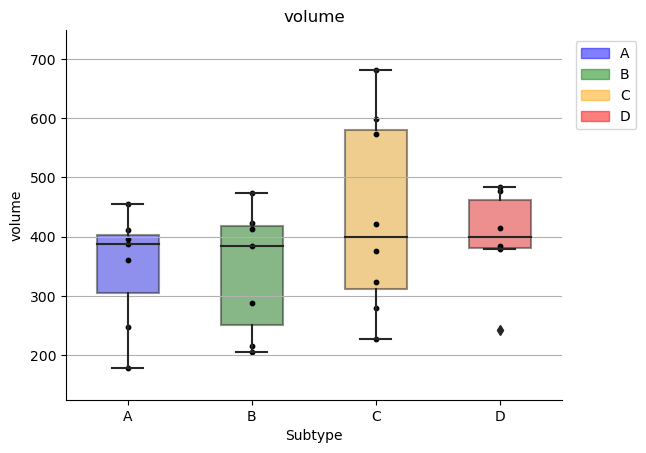

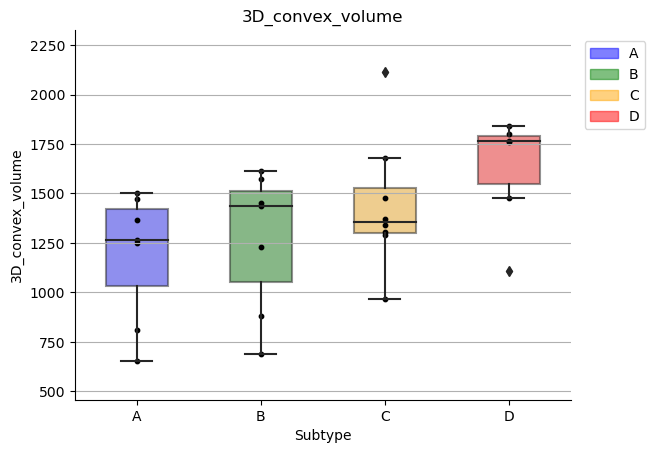

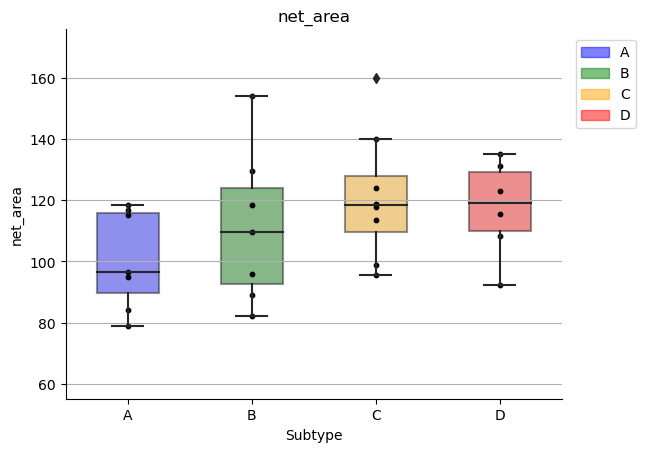

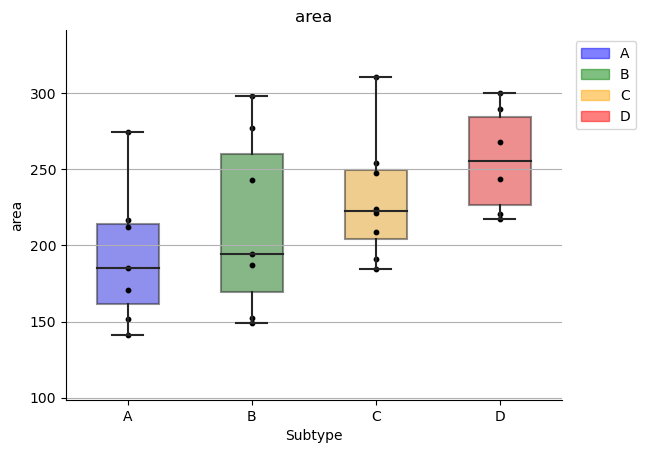

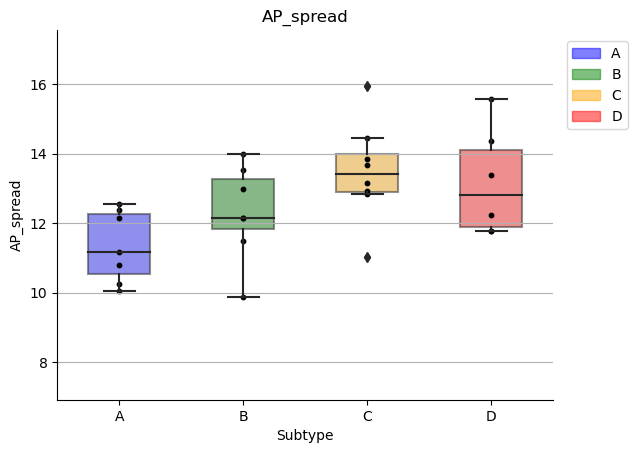

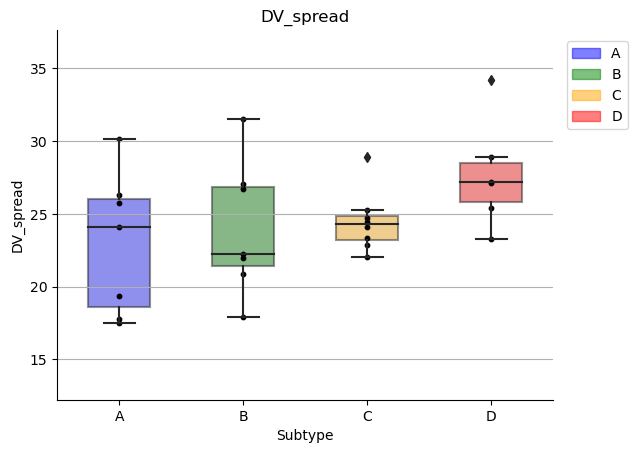

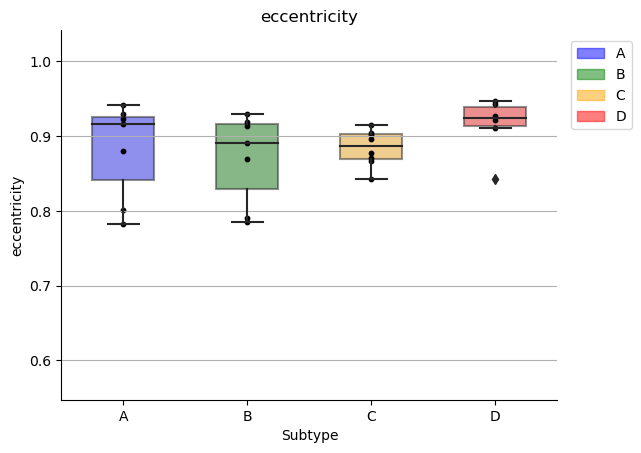

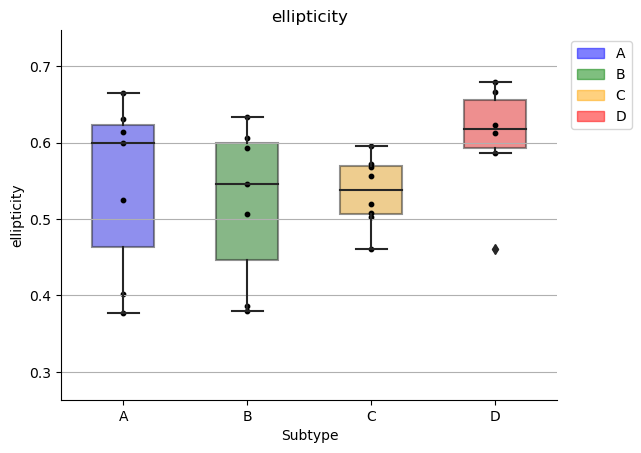

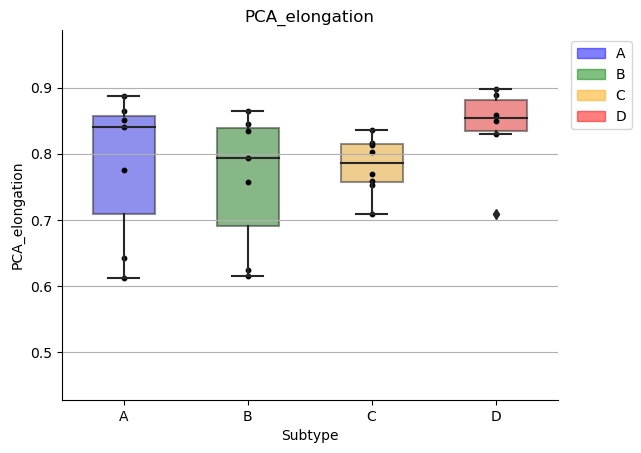

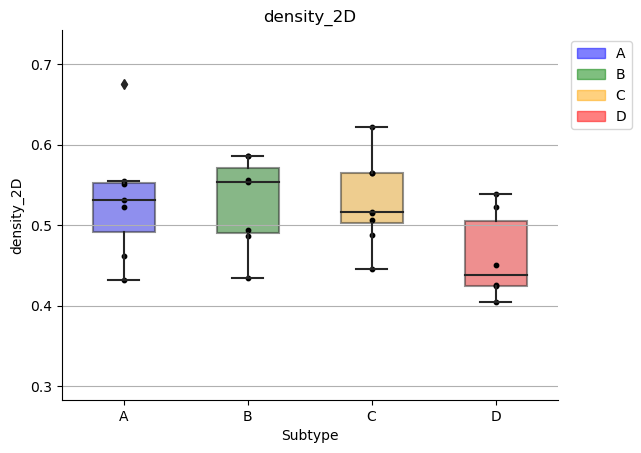

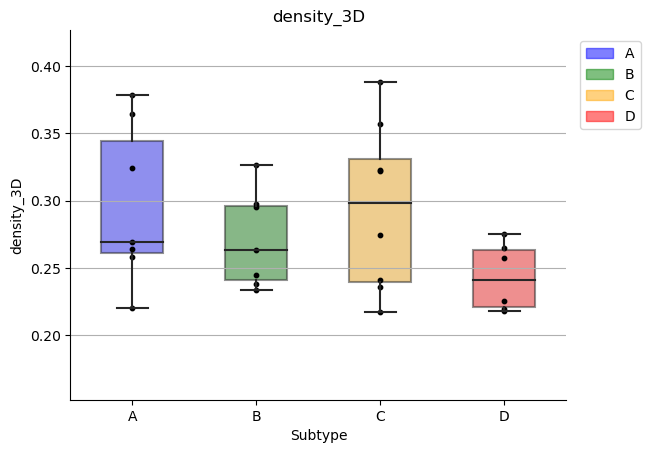

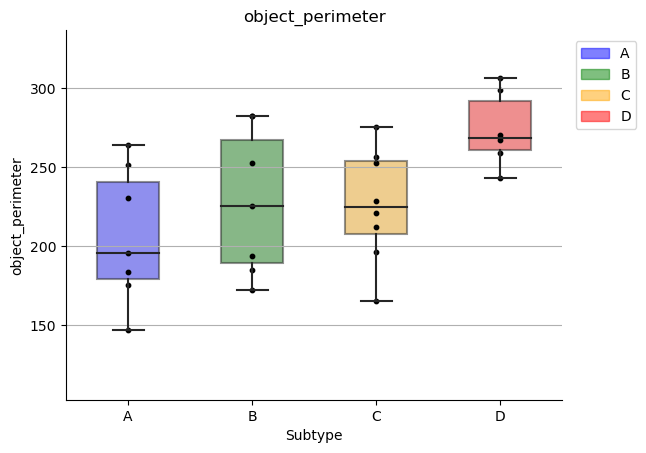

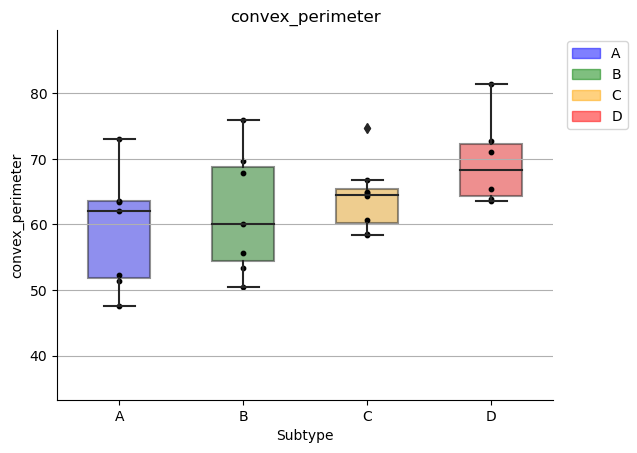

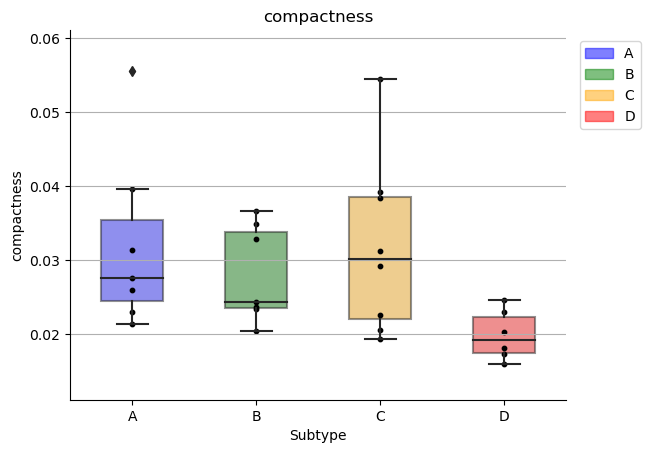

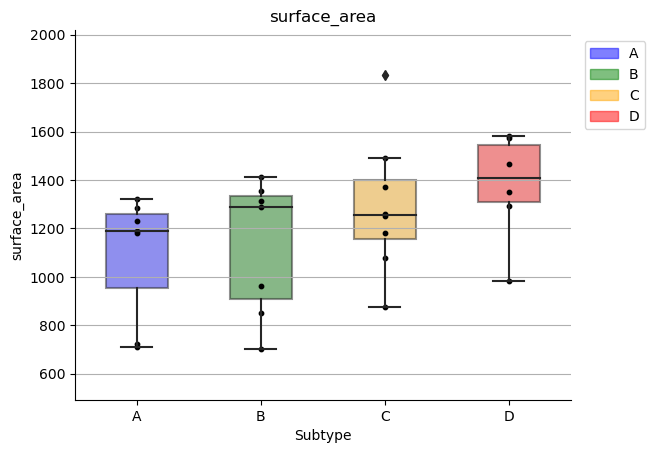

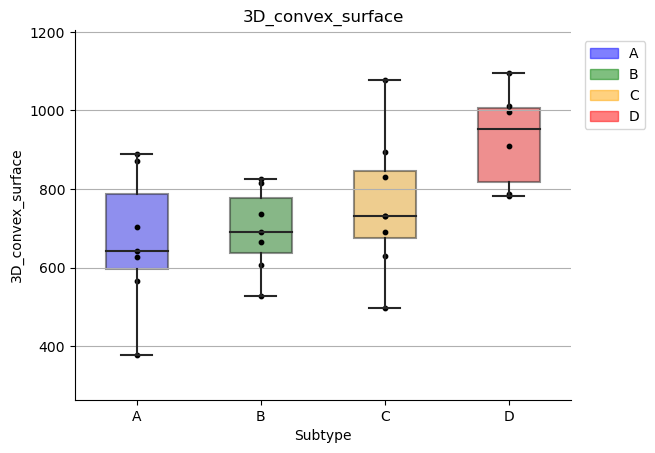

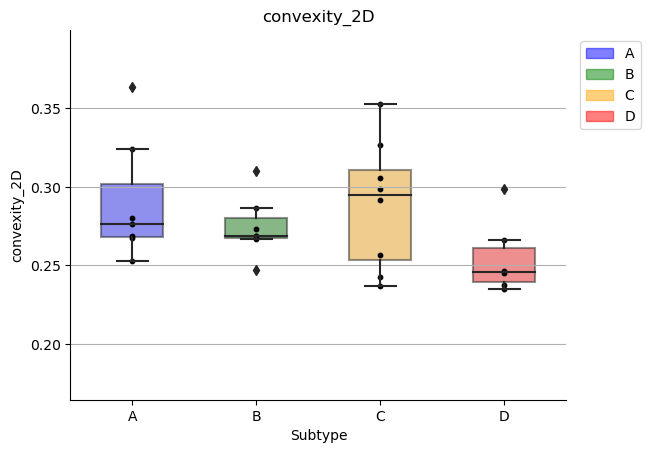

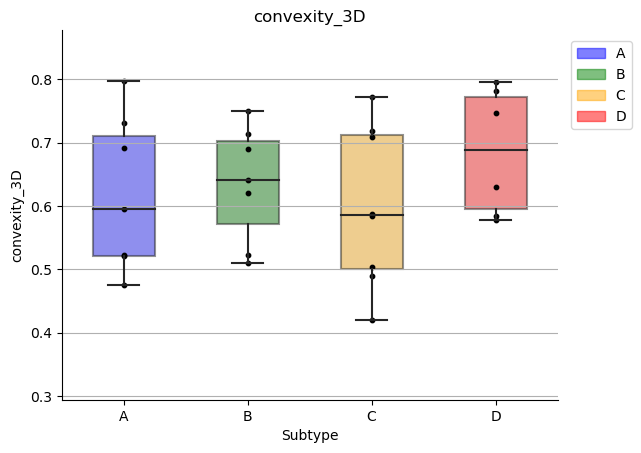

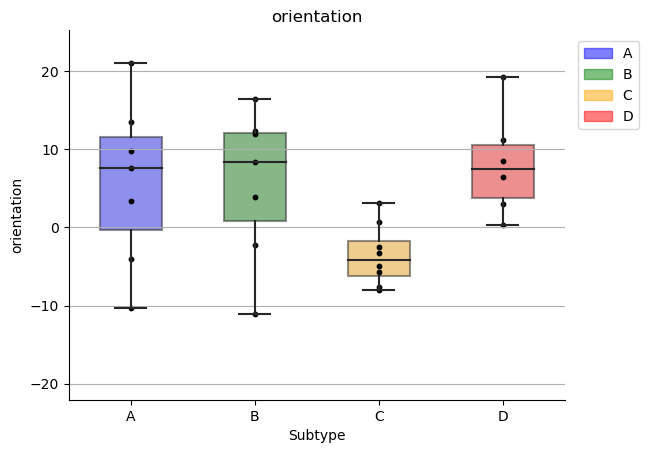

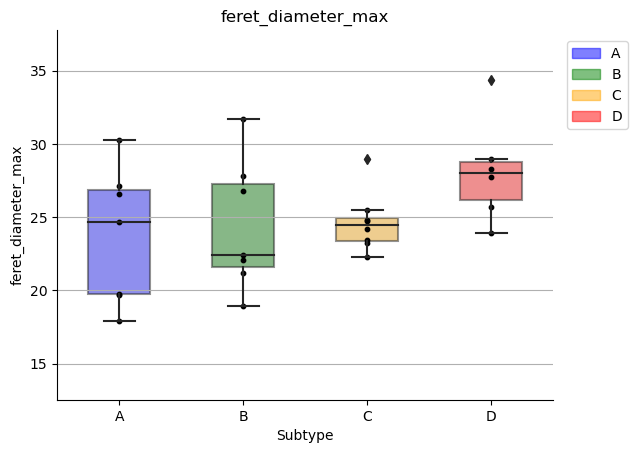

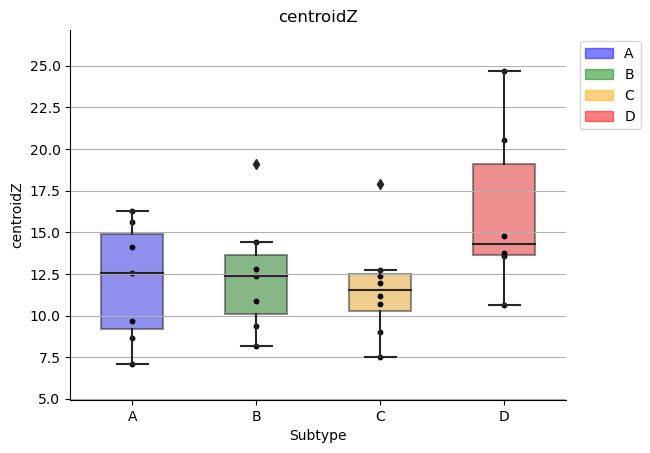

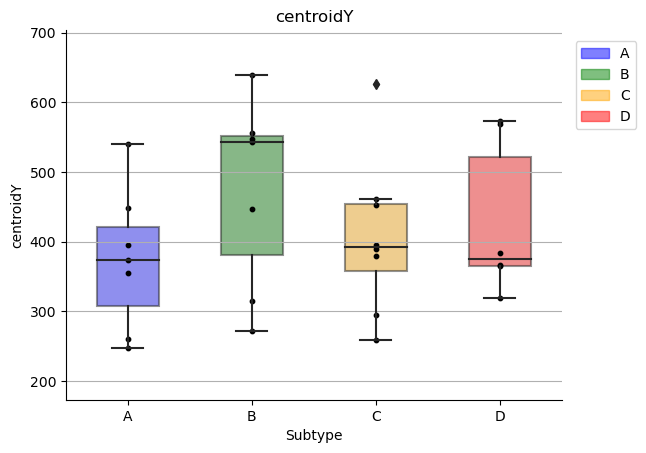

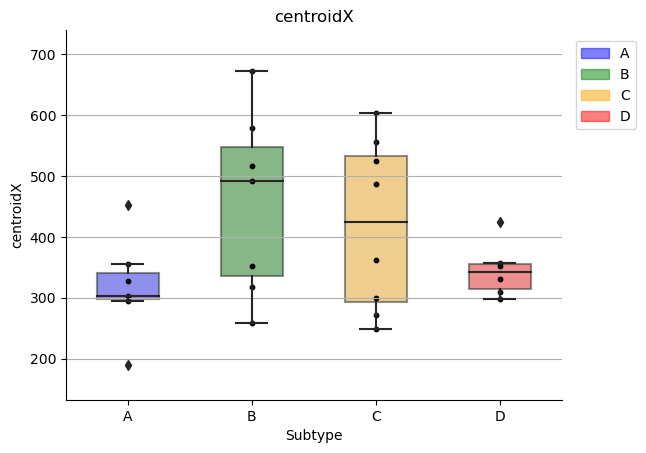

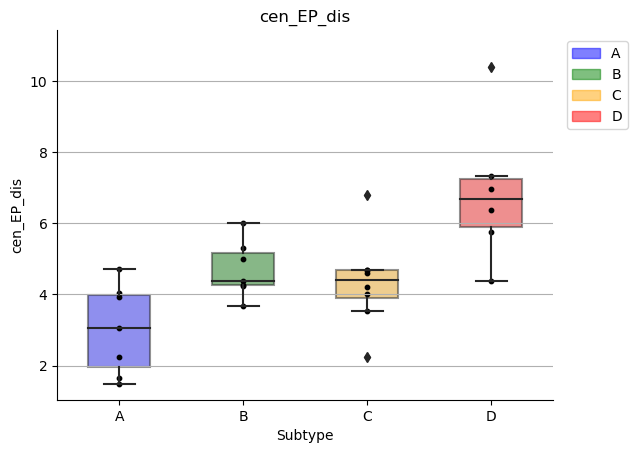

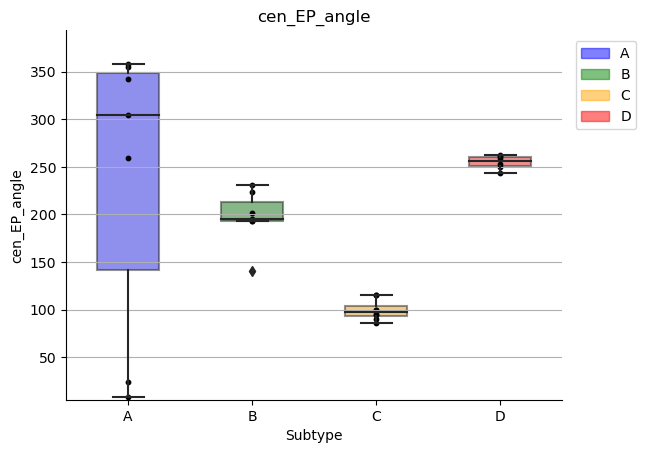

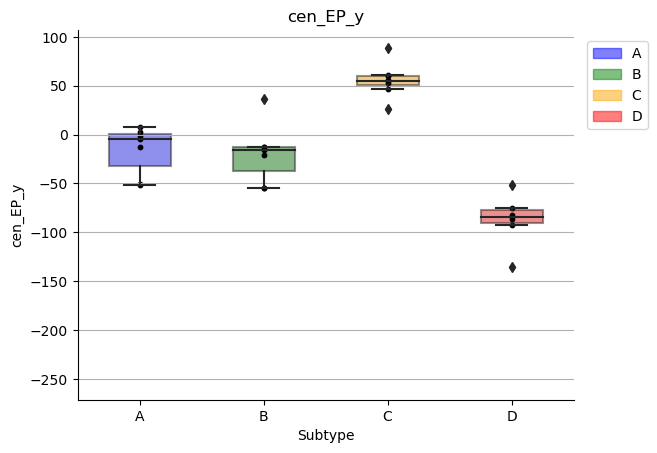

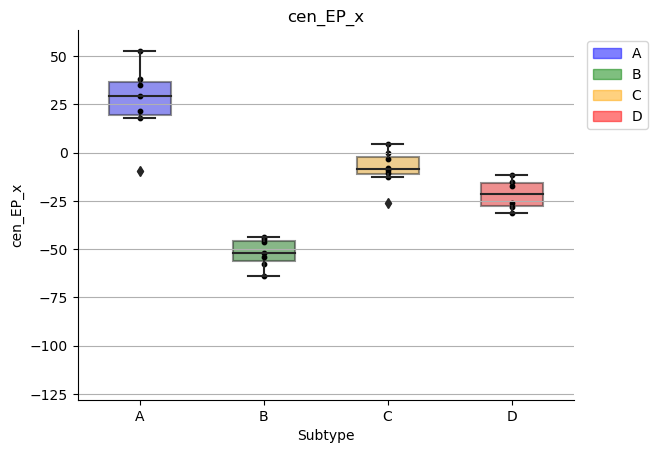

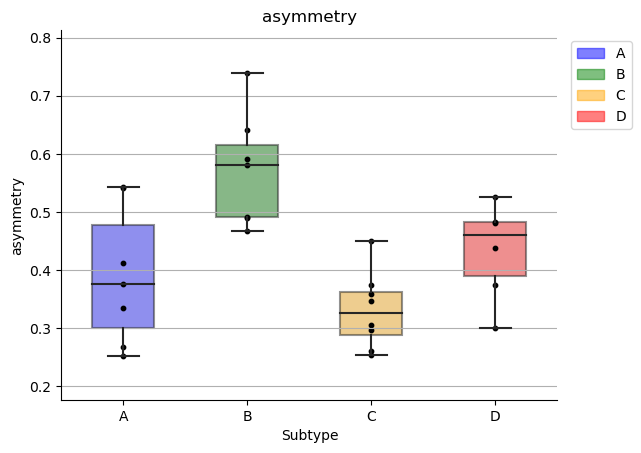

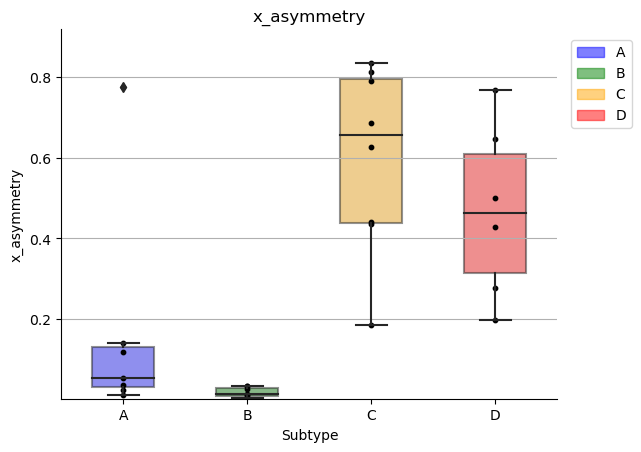

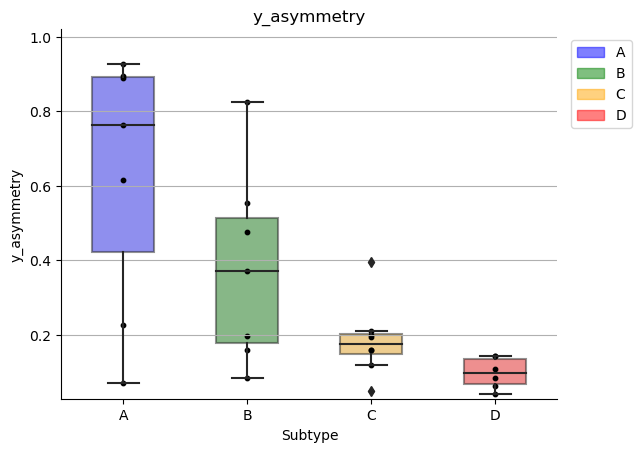

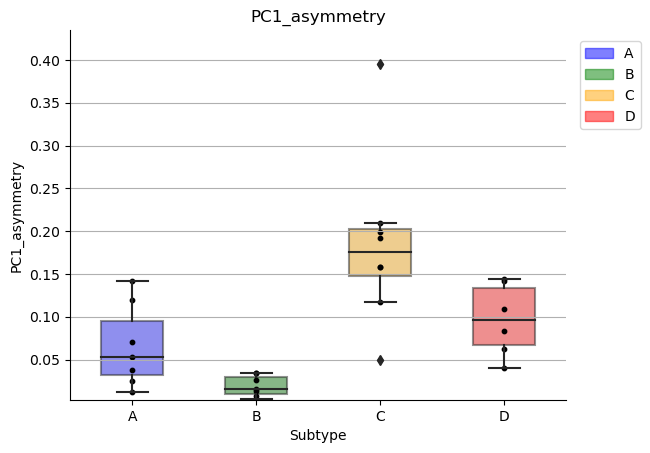

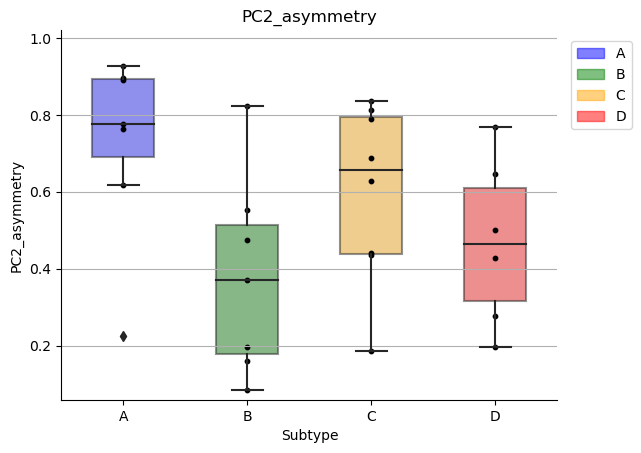

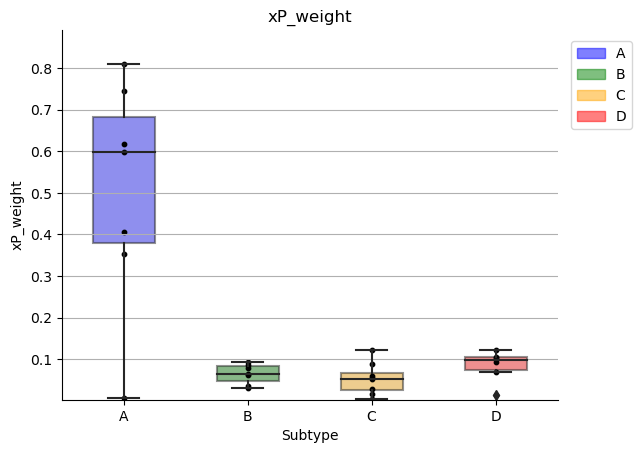

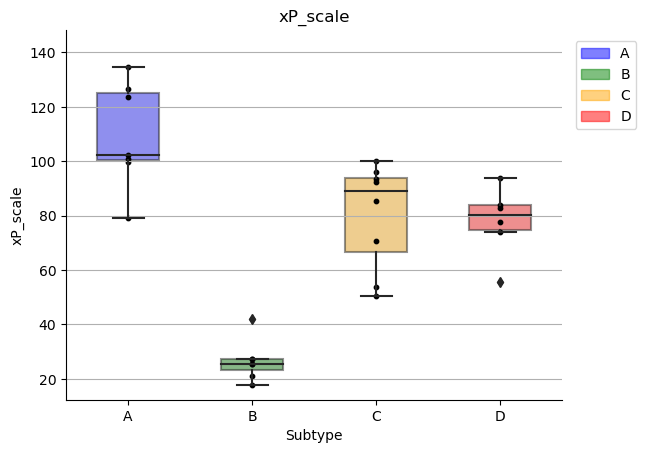

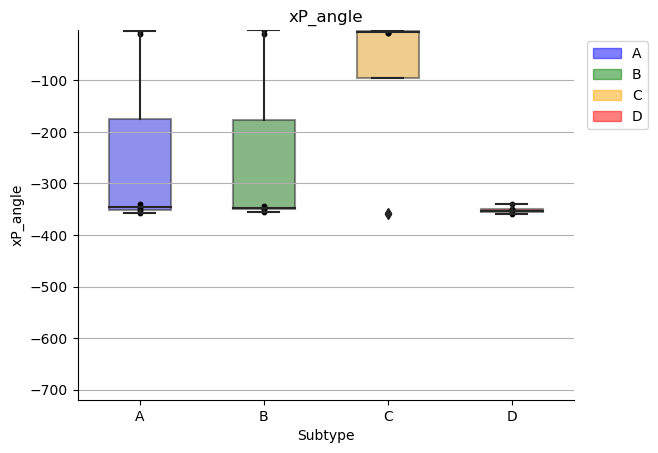

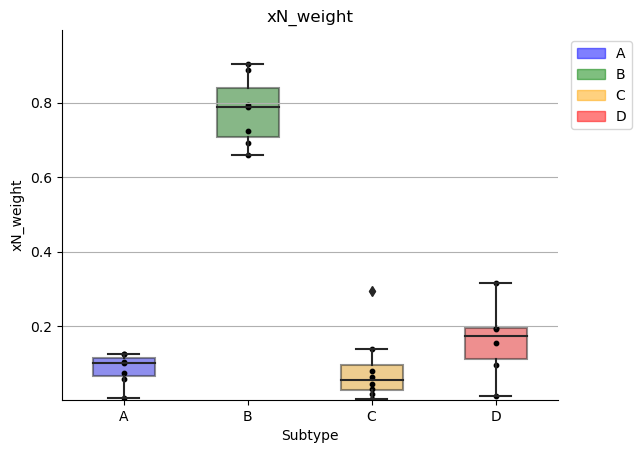

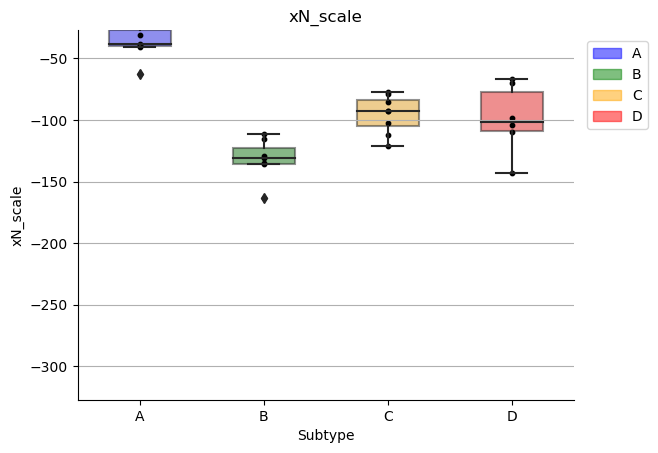

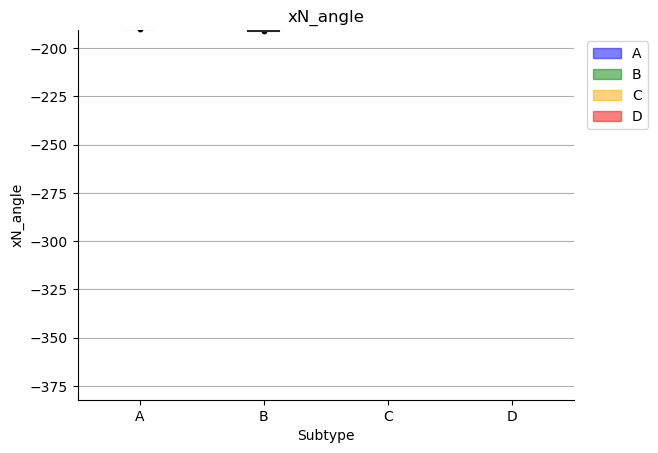

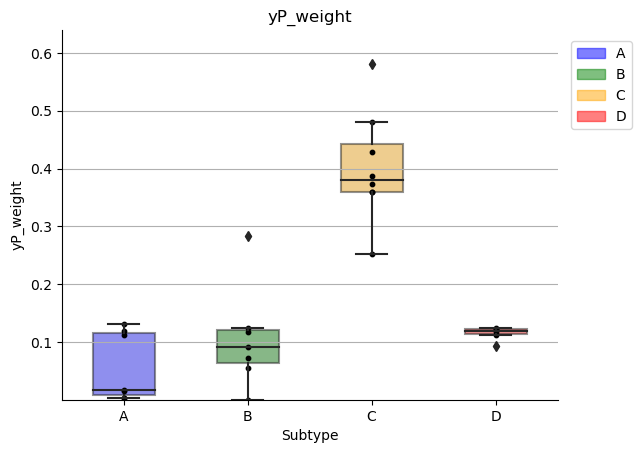

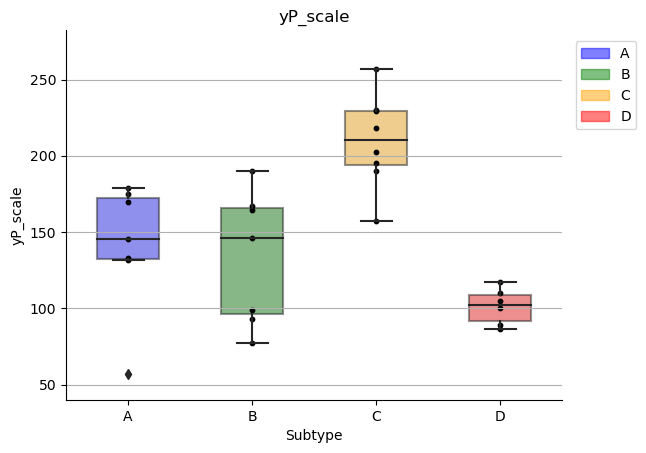

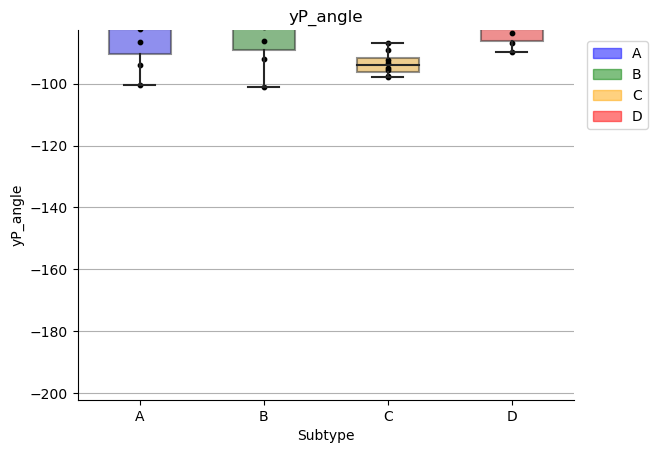

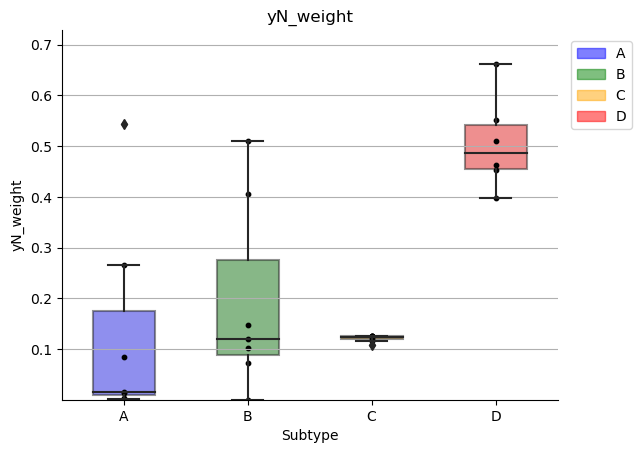

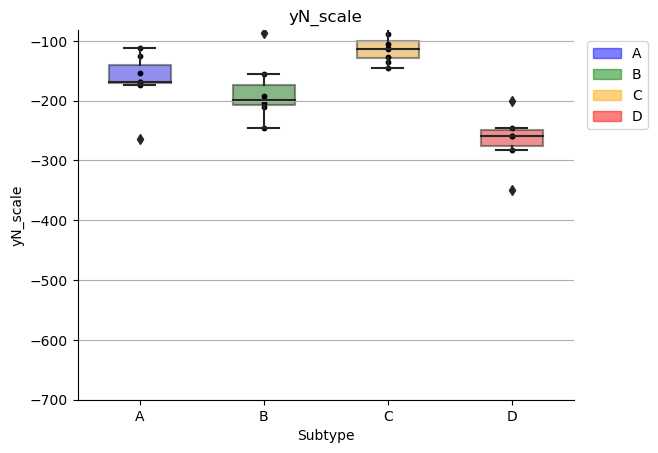

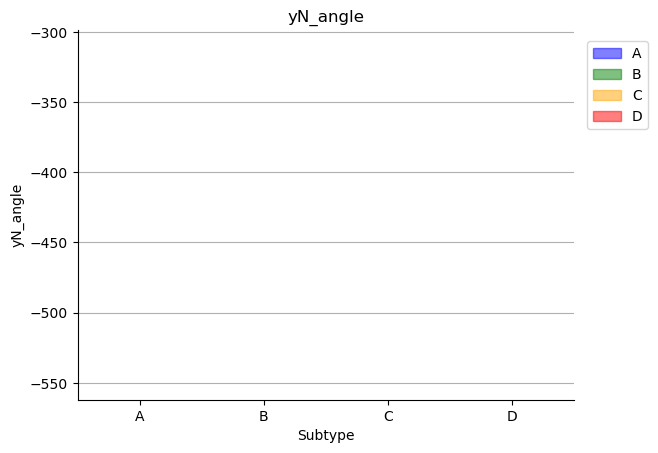

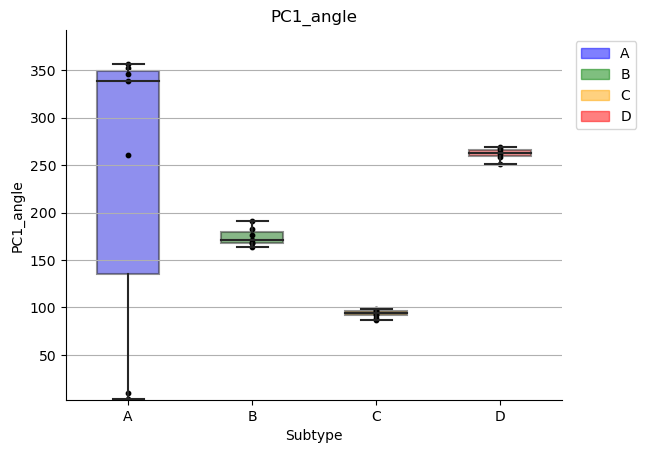

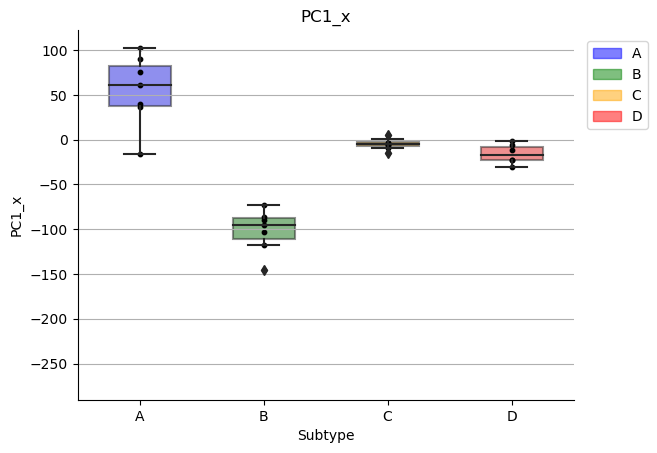

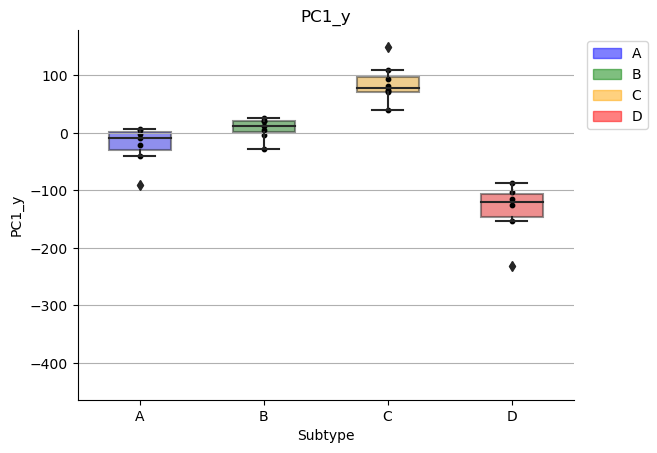

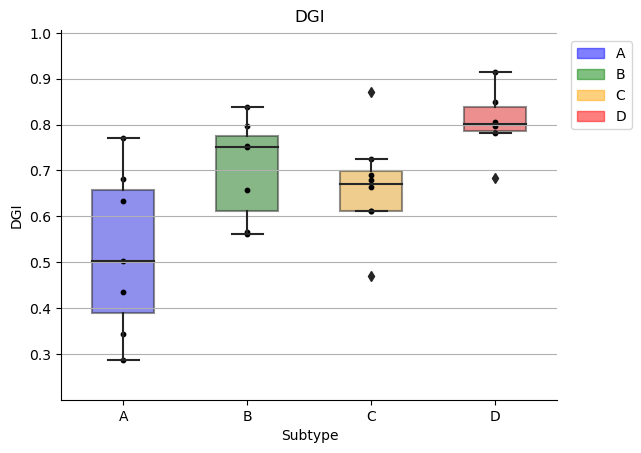

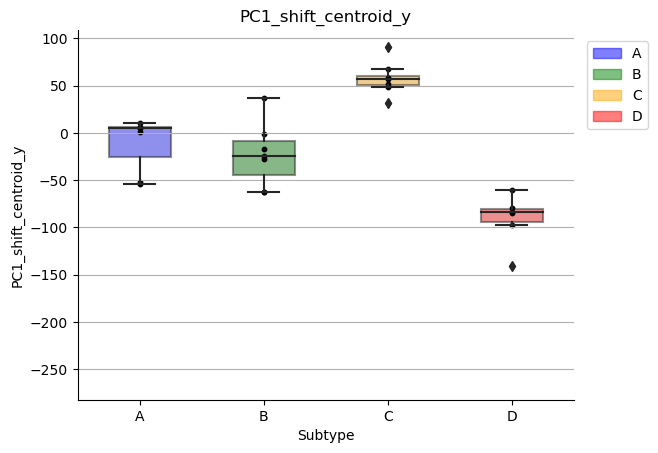

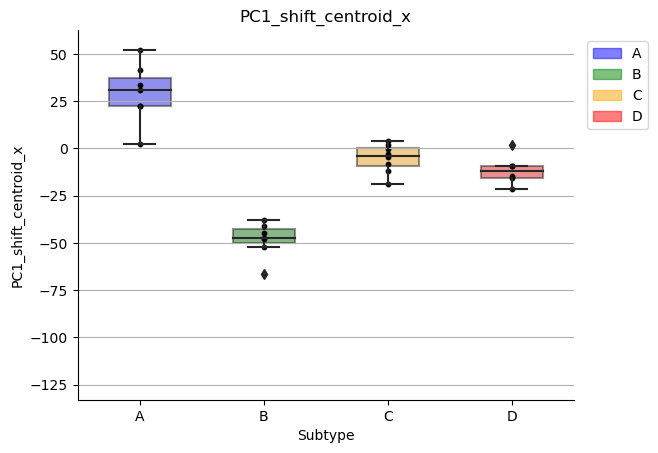

In [18]:
Colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':0,'B':1,'C':2,'D':3}
plt_order = ['A', 'B', 'C', 'D']
for plot_col in plot_cols:
    # y_vals = results_df[plot_col]
    fig, ax = plt.subplots(1)
    for i,neu in results_df.iterrows():
        ax.scatter(x_p[neu.subtype],neu[plot_col],c='k', marker='o', s=10)
    sns.boxplot(x=results_df.subtype, y=results_df[plot_col], 
                order=plt_order, width=0.5,
                palette=Colors, boxprops=dict(alpha=.5))

    ax.set_title(plot_col)
    ax.yaxis.grid(True)
    ax.set_xlabel('Subtype')
    ax.set_ylabel(plot_col)
    if results_df[plot_col].min() > 0:
        ax.set_ylim(0.7*results_df[plot_col].min(),1.1*results_df[plot_col].max())
    else:
        ax.set_ylim(2*results_df[plot_col].min(),1.2*results_df[plot_col].max())

    sns.despine()
    legend_patches = []
    for subtype,color in Colors.items():
        legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype,alpha=0.5))
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
                loc=1, borderaxespad=0., prop={'size': 10})
    # plt.savefig(save_path+plot_col+'.pdf', facecolor='white', transparent=False, bbox_inches='tight')

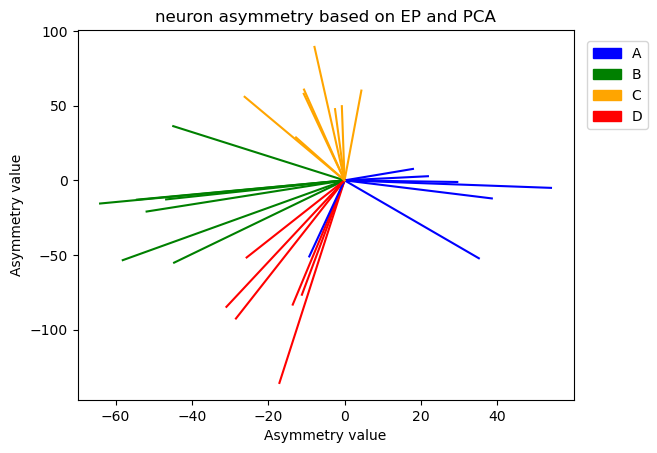

In [ ]:
# To plot x,y value of one metric for individual neurons, colored by subtype
fig, ax = plt.subplots(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.cen_EP_yx
for i,neu in enumerate(y_vals):
    ax.plot((0,neu[1]),(0,neu[0]),c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
plt.ylabel('Asymmetry value')
plt.xlabel('Asymmetry value')

legend_patches = []
for subtype,color in colors.items():
    legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
            loc=1, borderaxespad=0., prop={'size': 10})

# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)